# Pulling and Preparing the Data

## Setup

### Downloading kaggle data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55           1827  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           4241  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           2007  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           8026  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Tu

In [ ]:
! kaggle competitions download -c riiid-test-answer-prediction

  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 50.1kB/s]
  0% 0.00/445k [00:00<?, ?B/s]
100% 445k/445k [00:00<00:00, 50.2MB/s]
 99% 1.27G/1.29G [00:08<00:00, 195MB/s]
100% 1.29G/1.29G [00:08<00:00, 154MB/s]
  0% 0.00/971 [00:00<?, ?B/s]
100% 971/971 [00:00<00:00, 572kB/s]
  0% 0.00/5.99k [00:00<?, ?B/s]
100% 5.99k/5.99k [00:00<00:00, 3.79MB/s]
  0% 0.00/9.48k [00:00<?, ?B/s]
100% 9.48k/9.48k [00:00<00:00, 7.57MB/s]
  0% 0.00/289k [00:00<?, ?B/s]
100% 289k/289k [00:00<00:00, 64.6MB/s]


In [ ]:
! mkdir train
! unzip train.csv.zip -d train

Archive:  train.csv.zip
  inflating: train/train.csv         


### Spark initialization

In [ ]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F


import os
spark = SparkSession.builder.appName('Graphs-HW2')\
.config("spark.driver.maxResultSize", "2g")\
.config("spark.driver.memory", "15g")\
.config('spark.executor.memory','32g')\
.getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
import pandas as pd
import numpy as np

import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:

try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

### Loading Data into Spark

In [ ]:
df = spark.read.load('train/train.csv', 
                        format="csv",
                        header=True,
                        schema=StructType([
                    StructField("row_id", IntegerType(), nullable=False),
                    StructField("timestamp", IntegerType(), nullable=True),
                    StructField("user_id", IntegerType(), nullable=True),
                    StructField("content_id", IntegerType(), nullable=True),
                    StructField("content_type_id", IntegerType(), nullable=True),
                    StructField("task_container_id", IntegerType(), nullable=True),
                    StructField("user_answer", IntegerType(), nullable=True),
                    StructField("answered_correctly", IntegerType(), nullable=True),
                    StructField("prior_question_elapsed_time", FloatType(), nullable=True),
                    StructField("prior_question_had_explanation", BooleanType(), nullable=True),
                    ])
).drop('task_container_id').\
drop('user_answer')

In [ ]:
df.show()
df.createOrReplaceTempView("df")

+------+---------+-------+----------+---------------+------------------+---------------------------+------------------------------+
|row_id|timestamp|user_id|content_id|content_type_id|answered_correctly|prior_question_elapsed_time|prior_question_had_explanation|
+------+---------+-------+----------+---------------+------------------+---------------------------+------------------------------+
|     0|        0|    115|      5692|              0|                 1|                       null|                          null|
|     1|    56943|    115|      5716|              0|                 1|                    37000.0|                         false|
|     2|   118363|    115|       128|              0|                 1|                    55000.0|                         false|
|     3|   131167|    115|      7860|              0|                 1|                    19000.0|                         false|
|     4|   137965|    115|      7922|              0|                 1|    

In [ ]:
questions = spark.read.load('questions.csv', 
                        format="csv",
                        header=True).toPandas().set_index('question_id')
questions

,bundle_id,correct_answer,part,tags
question_id,,,,
0,0,0,1,51 131 162 38
1,1,1,1,131 36 81
2,2,0,1,131 101 162 92
3,3,0,1,131 149 162 29
4,4,3,1,131 5 162 38
...,...,...,...,...
13518,13518,3,5,14
13519,13519,3,5,8
13520,13520,2,5,73


In [ ]:
lectures = spark.read.load('lectures.csv', 
                        format="csv",
                        header=True).toPandas().set_index('lecture_id')
lectures

,tag,part,type_of
lecture_id,,,
89,159,5,concept
100,70,1,concept
185,45,6,concept
192,79,5,solving question
317,156,5,solving question
...,...,...,...
32535,8,5,solving question
32570,113,3,solving question
32604,24,6,concept


## Data Wrangling

### One hot encoding question and lecture tags to get sparse vector for each question

In [ ]:
question_tag_dummies = questions.tags.str.get_dummies(' ')
question_tag_dummies.columns = ['tag_' + c for c in question_tag_dummies.columns]
question_part_dummies = pd.get_dummies(questions.part,prefix='part')
question_ohe = pd.concat([question_tag_dummies,question_part_dummies],axis=1)
question_ohe.columns = ['question_' + c for c in question_ohe.columns]
question_ohe.reset_index(inplace=True)
question_ohe.rename(columns={'question_id':'content_id'},inplace=True)
question_ohe['content_type_id'] = 0
question_ohe

,content_id,question_tag_0,question_tag_1,question_tag_10,question_tag_100,question_tag_101,question_tag_102,question_tag_103,question_tag_104,question_tag_105,question_tag_106,question_tag_107,question_tag_108,question_tag_109,question_tag_11,question_tag_110,question_tag_111,question_tag_112,question_tag_113,question_tag_114,question_tag_115,question_tag_116,question_tag_117,question_tag_118,question_tag_119,question_tag_12,question_tag_120,question_tag_121,question_tag_122,question_tag_123,question_tag_124,question_tag_125,question_tag_126,question_tag_127,question_tag_128,question_tag_129,question_tag_13,question_tag_130,question_tag_131,question_tag_132,...,question_tag_70,question_tag_71,question_tag_72,question_tag_73,question_tag_74,question_tag_75,question_tag_76,question_tag_77,question_tag_78,question_tag_79,question_tag_8,question_tag_80,question_tag_81,question_tag_82,question_tag_83,question_tag_84,question_tag_85,question_tag_86,question_tag_87,question_tag_88,question_tag_89,question_tag_9,question_tag_90,question_tag_91,question_tag_92,question_tag_93,question_tag_94,question_tag_95,question_tag_96,question_tag_97,question_tag_98,question_tag_99,question_part_1,question_part_2,question_part_3,question_part_4,question_part_5,question_part_6,question_part_7,content_type_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13518,13518,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
13519,13519,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
13520,13520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
13521,13521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
lecture_ohe = pd.get_dummies(lectures).reset_index()
lecture_ohe.rename(columns={'lecture_id':'content_id'},inplace=True)
lecture_ohe['content_type_id'] = 1
lecture_ohe

,content_id,tag_0,tag_1,tag_101,tag_103,tag_104,tag_105,tag_106,tag_108,tag_109,tag_111,tag_112,tag_113,tag_114,tag_115,tag_116,tag_118,tag_119,tag_12,tag_120,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_13,tag_130,tag_132,tag_133,tag_134,tag_136,tag_137,tag_138,tag_139,tag_14,tag_140,tag_141,tag_142,...,tag_68,tag_69,tag_7,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_78,tag_79,tag_8,tag_80,tag_82,tag_83,tag_85,tag_89,tag_9,tag_90,tag_91,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving question,type_of_starter,content_type_id
0,89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
3,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
4,317,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,32535,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
414,32570,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
415,32604,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
416,32625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


### PCA and visualizations for Questions and Lectures

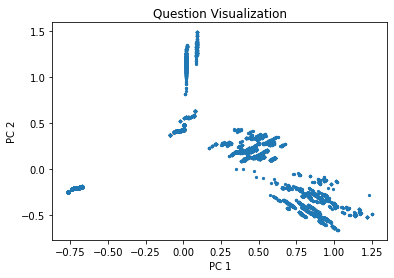

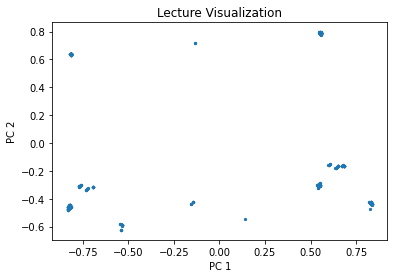

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_perc = .95

quest_arr = question_ohe.iloc[:,1:-1]
lect_arr = lecture_ohe.iloc[:,1:-1]

quest_arr_pca = PCA(pca_perc).fit_transform(quest_arr)
lect_arr_pca = PCA(pca_perc).fit_transform(lect_arr)

plt.scatter(quest_arr_pca[:,0], quest_arr_pca[:,1], s=5)
plt.title('Question Visualization')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

plt.scatter(lect_arr_pca[:,0], lect_arr_pca[:,1], s=5)
plt.title('Lecture Visualization')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()



### Joining sparse question and lecture vectors with user interaction data

In [ ]:
quest_lect_ohe = question_ohe.\
merge(lecture_ohe, how='outer', on=['content_id', 'content_type_id'])\
.fillna(0)
quest_lect_ohe

,content_id,question_tag_0,question_tag_1,question_tag_10,question_tag_100,question_tag_101,question_tag_102,question_tag_103,question_tag_104,question_tag_105,question_tag_106,question_tag_107,question_tag_108,question_tag_109,question_tag_11,question_tag_110,question_tag_111,question_tag_112,question_tag_113,question_tag_114,question_tag_115,question_tag_116,question_tag_117,question_tag_118,question_tag_119,question_tag_12,question_tag_120,question_tag_121,question_tag_122,question_tag_123,question_tag_124,question_tag_125,question_tag_126,question_tag_127,question_tag_128,question_tag_129,question_tag_13,question_tag_130,question_tag_131,question_tag_132,...,tag_67,tag_68,tag_69,tag_7,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_78,tag_79,tag_8,tag_80,tag_82,tag_83,tag_85,tag_89,tag_9,tag_90,tag_91,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving question,type_of_starter
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13936,32535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
13937,32570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13938,32604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
13939,32625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
%%time
quest_sdf = spark.createDataFrame(quest_lect_ohe)
quest_sdf.createOrReplaceTempView("quest")
quest_sdf.show()

+----------+--------------+--------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------+------------

In [ ]:
data_raw = spark.sql("select * from df natural join quest")
data_raw.createOrReplaceTempView("data")

### Randomly sampling user data for training. I sample from users instead of individual data points.

In [ ]:
%%time
user_ids = spark.sql("select distinct user_id from data")

sampled_user_ids = user_ids.sample(False, .01, seed=0)
sampled_user_ids.createOrReplaceTempView("users")


data = spark.sql("select * from data natural join users").toPandas()

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 36534)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/local/lib/python3.6/dist-packages/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/lib/python3.6/dist-packages/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/lo

CPU times: user 3min 1s, sys: 17.6 s, total: 3min 18s
Wall time: 21min 28s


In [ ]:
data

,user_id,content_id,content_type_id,row_id,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_tag_0,question_tag_1,question_tag_10,question_tag_100,question_tag_101,question_tag_102,question_tag_103,question_tag_104,question_tag_105,question_tag_106,question_tag_107,question_tag_108,question_tag_109,question_tag_11,question_tag_110,question_tag_111,question_tag_112,question_tag_113,question_tag_114,question_tag_115,question_tag_116,question_tag_117,question_tag_118,question_tag_119,question_tag_12,question_tag_120,question_tag_121,question_tag_122,question_tag_123,question_tag_124,question_tag_125,question_tag_126,...,tag_67,tag_68,tag_69,tag_7,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_78,tag_79,tag_8,tag_80,tag_82,tag_83,tag_85,tag_89,tag_9,tag_90,tag_91,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving question,type_of_starter
0,66180936,438,0,3051702,427394890.0,0,33000.0,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66180936,1676,0,3052045,733796190.0,1,22000.0,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,66180936,2319,0,3051820,453791781.0,1,23666.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,66180936,3986,0,3051728,430926279.0,0,23000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,66180936,4057,1,3051959,559712685.0,-1,NaN,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013440,2102383742,848,0,99096445,13912992.0,0,17000.0,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013441,2102383742,11952,0,99096443,13772651.0,0,16000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013442,2102383742,6443,0,99096439,108787.0,1,11000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Dropping extraneous columns and sorting based on time

In [ ]:
clean_data = data.sort_values(['user_id','timestamp'], na_position='last').drop(columns=['row_id'])
clean_data

,user_id,content_id,content_type_id,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_tag_0,question_tag_1,question_tag_10,question_tag_100,question_tag_101,question_tag_102,question_tag_103,question_tag_104,question_tag_105,question_tag_106,question_tag_107,question_tag_108,question_tag_109,question_tag_11,question_tag_110,question_tag_111,question_tag_112,question_tag_113,question_tag_114,question_tag_115,question_tag_116,question_tag_117,question_tag_118,question_tag_119,question_tag_12,question_tag_120,question_tag_121,question_tag_122,question_tag_123,question_tag_124,question_tag_125,question_tag_126,question_tag_127,...,tag_67,tag_68,tag_69,tag_7,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_78,tag_79,tag_8,tag_80,tag_82,tag_83,tag_85,tag_89,tag_9,tag_90,tag_91,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving question,type_of_starter
737897,381754,3951,0,0.0,1,NaN,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
737892,381754,3830,0,27838.0,1,27000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
737887,381754,9771,0,56690.0,1,21000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
737899,381754,5126,0,94423.0,0,26000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
737894,381754,8811,0,122602.0,1,35000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356196,2147262405,9468,0,NaN,1,11000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
356197,2147262405,8216,0,NaN,1,8000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
356203,2147262405,4021,0,NaN,1,8000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Splitting into train and test

In [ ]:
train_perc = .8
val_perc = .9

user_ids = clean_data.index.unique()
train_val_split = int(np.round(train_perc*len(user_ids)))
val_test_split = int(np.round(val_perc*len(user_ids)))

train_ids = user_ids[:train_val_split]
val_ids = user_ids[train_val_split:val_test_split]
test_ids = user_ids[val_test_split:]

train = clean_data[clean_data.index.isin(train_ids)]
val = clean_data[clean_data.index.isin(val_ids)]
test = clean_data[clean_data.index.isin(test_ids)]

In [ ]:
train

,user_id,content_id,content_type_id,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_tag_0,question_tag_1,question_tag_10,question_tag_100,question_tag_101,question_tag_102,question_tag_103,question_tag_104,question_tag_105,question_tag_106,question_tag_107,question_tag_108,question_tag_109,question_tag_11,question_tag_110,question_tag_111,question_tag_112,question_tag_113,question_tag_114,question_tag_115,question_tag_116,question_tag_117,question_tag_118,question_tag_119,question_tag_12,question_tag_120,question_tag_121,question_tag_122,question_tag_123,question_tag_124,question_tag_125,question_tag_126,question_tag_127,...,tag_67,tag_68,tag_69,tag_7,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_78,tag_79,tag_8,tag_80,tag_82,tag_83,tag_85,tag_89,tag_9,tag_90,tag_91,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving question,type_of_starter
737897,381754,3951,0,0.0,1,NaN,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
737892,381754,3830,0,27838.0,1,27000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
737887,381754,9771,0,56690.0,1,21000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
737899,381754,5126,0,94423.0,0,26000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
737894,381754,8811,0,122602.0,1,35000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977984,1719102216,5988,0,NaN,0,207000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
977985,1719102216,6300,0,NaN,1,121000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
977987,1719102216,8539,0,NaN,0,70000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
val

,user_id,content_id,content_type_id,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_tag_0,question_tag_1,question_tag_10,question_tag_100,question_tag_101,question_tag_102,question_tag_103,question_tag_104,question_tag_105,question_tag_106,question_tag_107,question_tag_108,question_tag_109,question_tag_11,question_tag_110,question_tag_111,question_tag_112,question_tag_113,question_tag_114,question_tag_115,question_tag_116,question_tag_117,question_tag_118,question_tag_119,question_tag_12,question_tag_120,question_tag_121,question_tag_122,question_tag_123,question_tag_124,question_tag_125,question_tag_126,question_tag_127,...,tag_67,tag_68,tag_69,tag_7,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_78,tag_79,tag_8,tag_80,tag_82,tag_83,tag_85,tag_89,tag_9,tag_90,tag_91,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving question,type_of_starter
977990,1719102216,735,0,NaN,1,17000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
977992,1719102216,5199,0,NaN,1,89000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
977994,1719102216,5558,0,NaN,0,27000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
977996,1719102216,5707,0,NaN,1,15000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
977997,1719102216,9853,0,NaN,0,27000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615955,1940134069,8665,0,NaN,1,15000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615956,1940134069,9679,0,NaN,1,24000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615957,1940134069,273,0,NaN,1,16000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
test

,user_id,content_id,content_type_id,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_tag_0,question_tag_1,question_tag_10,question_tag_100,question_tag_101,question_tag_102,question_tag_103,question_tag_104,question_tag_105,question_tag_106,question_tag_107,question_tag_108,question_tag_109,question_tag_11,question_tag_110,question_tag_111,question_tag_112,question_tag_113,question_tag_114,question_tag_115,question_tag_116,question_tag_117,question_tag_118,question_tag_119,question_tag_12,question_tag_120,question_tag_121,question_tag_122,question_tag_123,question_tag_124,question_tag_125,question_tag_126,question_tag_127,...,tag_67,tag_68,tag_69,tag_7,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_78,tag_79,tag_8,tag_80,tag_82,tag_83,tag_85,tag_89,tag_9,tag_90,tag_91,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving question,type_of_starter
615960,1940134069,469,0,NaN,1,11000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615961,1940134069,481,0,NaN,1,13000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615962,1940134069,598,0,NaN,1,15000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615963,1940134069,608,0,NaN,1,14000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615964,1940134069,830,0,NaN,1,19000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356196,2147262405,9468,0,NaN,1,11000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
356197,2147262405,8216,0,NaN,1,8000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
356203,2147262405,4021,0,NaN,1,8000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Number of users in train and test respectively.

In [ ]:
print(train.user_id.nunique())
print(val.user_id.nunique())
print(test.user_id.nunique())

3161
412
409


In [ ]:
train.to_csv('drive/MyDrive/data/train.csv',index=False)
val.to_csv('drive/MyDrive/data/val.csv',index=False)
test.to_csv('drive/MyDrive/data/test.csv',index=False)

# Training the Model

## Importing Pytorch dependencies

In [ ]:
#Download and unzip files
!pip3 install scikit-learn
!sudo apt-get install unzip
from os.path import exists
!pip install "wheel==0.34.2"
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torch torchvision
  
import torch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
  Found existing installation: wheel 0.36.1
    Uninstalling wheel-0.36.1:
      Successfully uninstalled wheel-0.36.1
     |████████████████████████████████| 614.8MB 26kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.0.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [ ]:
import torch.nn as nn
from torch.autograd import Variable
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import numpy as np
import copy
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import codecs
import random
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Verify CUDA acceleration should print cuda:0
print(device)

cuda:0


## Defining RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

##  Utility functions for training

In [ ]:
def preprocessing_pipeline(data,train=True,prePipeline=None):
  assert train == (prePipeline == None)

  data['prior_question_had_explanation']=data['prior_question_had_explanation'].astype(float)

  columns_to_preprocess = ['content_id',	'timestamp', 'prior_question_elapsed_time',	'prior_question_had_explanation']

  if prePipeline is None:
    prePipeline = Pipeline([('imputer',SimpleImputer()),('scaler',MinMaxScaler())])
    prePipeline.fit(data[columns_to_preprocess])
  
  data[columns_to_preprocess]=prePipeline.transform(data[columns_to_preprocess])
  
  labels = data[['answered_correctly']].to_numpy()
  user_ids = data['user_id'].to_numpy()
  content_types = data['content_type_id'].to_numpy()
  features = data.drop(columns=['answered_correctly','user_id']).to_numpy().reshape((len(labels),1,-1)).astype(float)

  return features, labels, user_ids, content_types, prePipeline

def readData(baseDir, data_type='train',pipeline=None):
    
    assert data_type in ['train','val','test']

    print("Read {} data into memory".format(data_type))
    df = pd.read_csv(baseDir+data_type+'.csv')

    print("Preprocessing")
    #Preprocessing
    features, labels, user_ids, content_types, prePipeline = preprocessing_pipeline(df,
                                                                                    train=(data_type=='train'),
                                                                                    prePipeline=pipeline)

    #Gathering unique user ids
    u_list = df.user_id.unique()

    #Shuffling order of user ids for training
    random.shuffle(u_list)

    return features, labels, user_ids, u_list, content_types, prePipeline


def trainOneUser(model, criterion, optimizer, X, y, content_types):

    hidden = model.initHidden().to(device)
    optimizer.zero_grad()
    pred = []
    loss = 0

    for i in range(X.size()[0]):
        output, hidden = model(X[i], hidden)
        
        if content_types[i] == 0:

          loss += criterion(output, y[i])

          prediction = int(torch.argmax(output))
          pred.append(prediction)

    loss.backward()
    optimizer.step()

    return model, np.array(pred), loss.item()/len(pred), optimizer

@torch.no_grad()
def evaluate(model, criterion, X_val, y_val, u_val,content_types_val):
    
    model.eval()
    X = torch.tensor(X_val, dtype=torch.float).to(device)
    y = torch.tensor(y_val, dtype=torch.long).to(device)
    hidden = model.initHidden().to(device)

    loss_list = []
    pred = []
    pred_proba = []


    for row in range(X.size()[0]):
      
      if row > 0:
        
        #Checking if its a new user
        if u_val[row] != u_val[row-1]:
          
          #if so we zero the hidden state
          hidden = model.initHidden().to(device)
      
      question = X[row]
      label = y[row]
      
      output, hidden = model(question, hidden)
      
      if content_types_val[row] == 0:
        loss = criterion(output, label).item()
        loss_list.append(loss)

        prediction = int(torch.argmax(output))
        pred.append(prediction)

        probability_correct = np.exp(torch.flatten(output).tolist()[1])
        pred_proba.append(probability_correct)
    
    
    avg_loss = np.mean(loss_list)
    acc = accuracy_score(y_val[content_types_val == 0,0], np.array(pred))

    return acc, avg_loss, np.array(pred), np.array(pred_proba)


## Training function

In [ ]:
def run(hidden=128,
        lr=.0005, 
        display_progress=False,
        baseDir='/content',
        display_every=10,
        num_users_train=None,
        epochs=1):

  loss_list = []
  acc_list = []
  val_acc_list = []
  val_loss_list = []

  criterion = nn.NLLLoss()
  X, y, u, u_list, content_types, prePipeline = readData(baseDir)

  X_val, y_val, u_val, _ ,content_types_val, _  = readData(baseDir, data_type='val',pipeline=prePipeline)

  model=RNN(X.shape[2],hidden,2)
  model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  if num_users_train == None:
    iter_list = u_list
  else:
    iter_list = u_list[:num_users_train+1]
  print("Beginning Training:\n")
  for epoch in range(epochs):
    print("EPOCH:",epoch)
    for count, id in enumerate(iter_list):
      
      if count % display_every == 0:
        
        val_acc, val_loss, _, _ = evaluate(model, criterion, X_val, y_val, u_val,content_types_val)

        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        if display_progress:
          print("User Number:",count)
          print("Validation Accuracy:",val_acc)
          print("Validation Loss:",val_loss)
          print('\n')

      cur_rows = (u == id)
      cur_X = torch.tensor(X[cur_rows], dtype=torch.float).to(device)
      cur_y = torch.tensor(y[cur_rows], dtype=torch.long).to(device)
      curr_content_types = content_types[cur_rows]

      model, pred, loss, optimizer = trainOneUser(model, criterion, optimizer, cur_X, cur_y, curr_content_types)

      acc_list.append(accuracy_score(y[cur_rows,0][curr_content_types == 0], pred))

      loss_list.append(loss)
    print("\n\n\n\n")
  print("Final Validation Accuracy:",val_acc)
  print("Final Validation Loss:",val_loss)
  

  _, _, _, pred_proba = evaluate(model, criterion, X_val, y_val, u_val,content_types_val)

  model.eval()
  torch.save(model.state_dict(), baseDir + "myModel")

  def moving_average(a, n=display_every) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

  plt.plot(list(range(len(moving_average(loss_list)))),moving_average(loss_list),label='Training')
  plt.plot(list(range(0,display_every*len(val_loss_list),display_every)),val_loss_list,label='Validation')
  plt.title('Loss')
  plt.xlabel('Users')
  plt.ylabel('Loss')
  plt.legend(loc='best')
  plt.show()
  plt.close()

  plt.plot(list(range(len(moving_average(acc_list)))),moving_average(acc_list),label='Training')
  plt.plot(list(range(0,display_every*len(val_acc_list),display_every)),val_acc_list,label='Validation')
  plt.title('Accuracy')
  plt.xlabel('Users')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.show()

  plt.figure()

  fpr, tpr, _ = roc_curve(y_val[content_types_val == 0,0],pred_proba,drop_intermediate=False)
  roc_auc = roc_auc_score(y_val[content_types_val == 0,0],pred_proba)

  plt.plot(fpr, tpr)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Final Validation ROC: %0.2f' % roc_auc)

  plt.show()

## Training and Evaluation

Reloading data (if neccesary)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Training the model across different choice of hyperparameters.

Training with hidden size: 128 and learning rate: 5e-06
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.4365029038459603
Validation Loss: 0.699058373732528


User Number: 200
Validation Accuracy: 0.6760576139143039
Validation Loss: 0.6483039167591808


User Number: 400
Validation Accuracy: 0.6761884631256857
Validation Loss: 0.636673571572971


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6278780931690974


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6256398609014603


User Number: 1000
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6249417378176964


User Number: 1200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6248641655447043


User Number: 1400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6241933585057372


User Number: 1600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6240952008488738


User Number: 1800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.62271520863088


User Nu

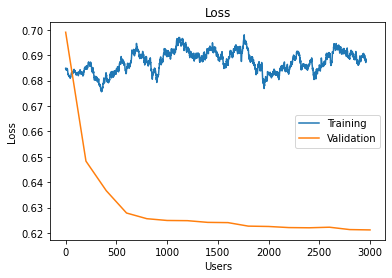

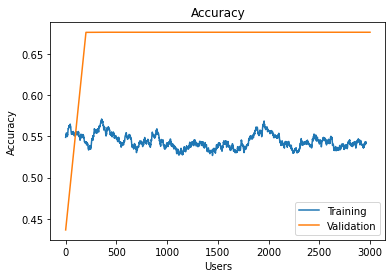

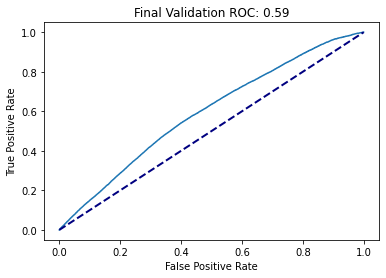





Training with hidden size: 128 and learning rate: 1e-05
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.4429447111755292
Validation Loss: 0.6983443425268778


User Number: 200
Validation Accuracy: 0.6761482018298759
Validation Loss: 0.654319678666138


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6348284606441595


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6283190959897841


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6238697247436626


User Number: 1000
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6233094047582033


User Number: 1200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.622152433883881


User Number: 1400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6210355907968075


User Number: 1600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6200329753946074


User Number: 1800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6197724651375316


User 

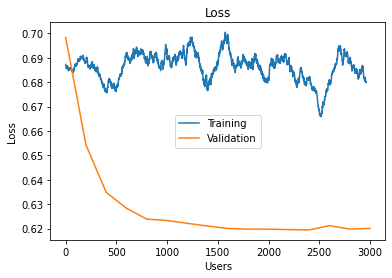

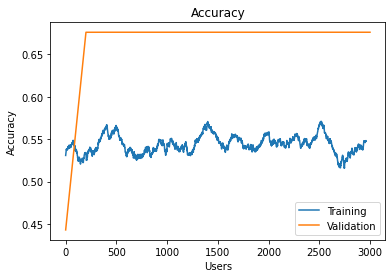

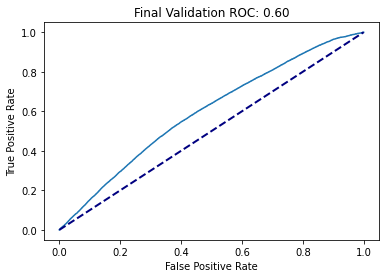





Training with hidden size: 128 and learning rate: 5e-05
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.47572747128866344
Validation Loss: 0.6959646431584143


User Number: 200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6238209708829627


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6191507115648303


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6213580038377469


User Number: 800
Validation Accuracy: 0.6762186590975431
Validation Loss: 0.6198450142866945


User Number: 1000
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6174415295946224


User Number: 1200
Validation Accuracy: 0.677597608479029
Validation Loss: 0.6175803529689889


User Number: 1400
Validation Accuracy: 0.6804058338617628
Validation Loss: 0.6214217081537156


User Number: 1600
Validation Accuracy: 0.6799830902557599
Validation Loss: 0.616676320829979


User Number: 1800
Validation Accuracy: 0.6785638795784642
Validation Loss: 0.6155867933404472


User

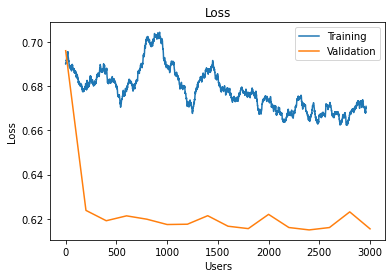

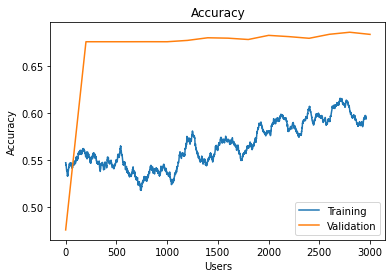

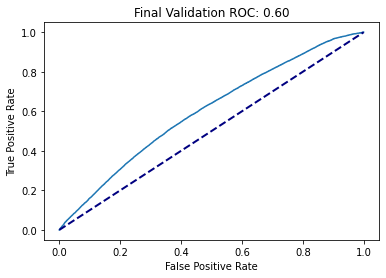





Training with hidden size: 256 and learning rate: 5e-06
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.35420881521071756
Validation Loss: 0.7098414410737377


User Number: 200
Validation Accuracy: 0.6757757848436352
Validation Loss: 0.659113956656106


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.642971588024787


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.631768847099842


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6292344480670453


User Number: 1000
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6260884733270554


User Number: 1200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6238526682675108


User Number: 1400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6229912928345303


User Number: 1600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6215442768445215


User Number: 1800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6212597876099354


User 

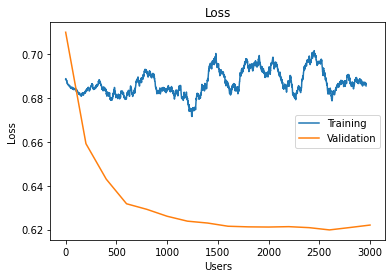

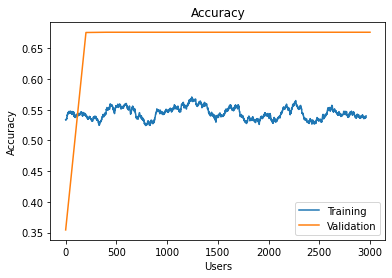

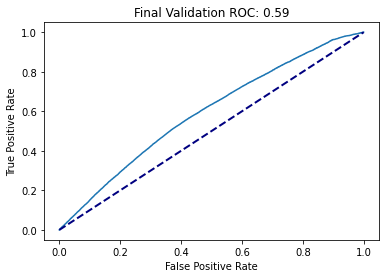





Training with hidden size: 256 and learning rate: 1e-05
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.6446739338305604
Validation Loss: 0.677382773715819


User Number: 200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6383887560006108


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6293741702653085


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.623891553841372


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6219410397188637


User Number: 1000
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6212938094175455


User Number: 1200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6231952394718956


User Number: 1400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6221333697251209


User Number: 1600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6226698917739819


User Number: 1800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6228661262634839


User 

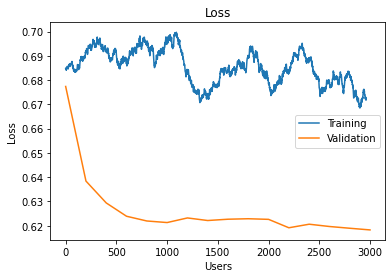

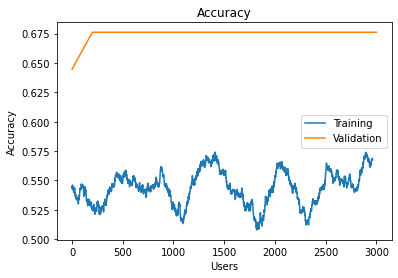

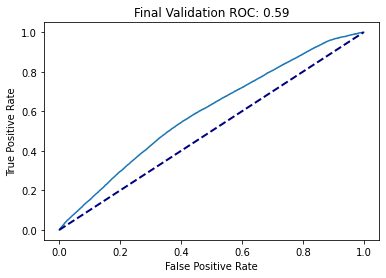





Training with hidden size: 256 and learning rate: 5e-05
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.5802961218306811
Validation Loss: 0.6876831932495796


User Number: 200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6257091819075538


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6195339675676221


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6187916162079977


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6178558524640088


User Number: 1000
Validation Accuracy: 0.6761884631256857
Validation Loss: 0.6165361385979787


User Number: 1200
Validation Accuracy: 0.678624271522179
Validation Loss: 0.6187313654025816


User Number: 1400
Validation Accuracy: 0.6795200853539471
Validation Loss: 0.616098154682417


User Number: 1600
Validation Accuracy: 0.6843615061750763
Validation Loss: 0.632532744916415


User Number: 1800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6207069099085019


User N

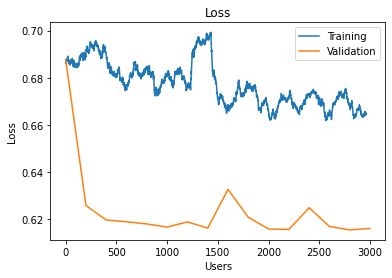

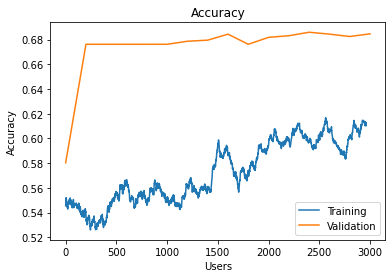

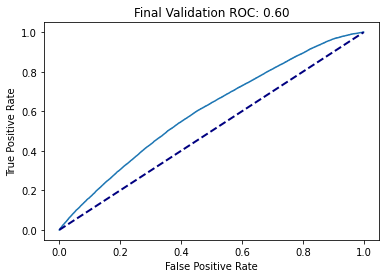





Training with hidden size: 512 and learning rate: 5e-06
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.6318809070869946
Validation Loss: 0.6830332040945127


User Number: 200
Validation Accuracy: 0.6768527745065475
Validation Loss: 0.6579309147055993


User Number: 400
Validation Accuracy: 0.6768125132107377
Validation Loss: 0.6459429517954237


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6356218037698901


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6279680635726664


User Number: 1000
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6243039677607355


User Number: 1200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6244686196057255


User Number: 1400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6243286776692168


User Number: 1600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6234300834389441


User Number: 1800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6205397147616184


Use

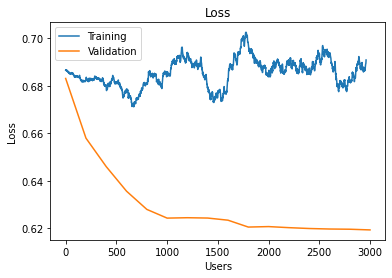

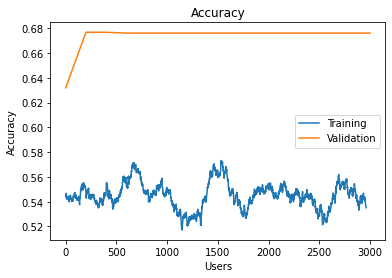

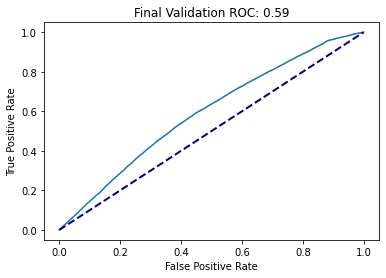





Training with hidden size: 512 and learning rate: 1e-05
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.5941862688850641
Validation Loss: 0.6874448302867213


User Number: 200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6377869616672401


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.624562099129491


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6240645154570155


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6244722208749153


User Number: 1000
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6220283257150874


User Number: 1200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6219723762246179


User Number: 1400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6205294231822716


User Number: 1600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6200801292508671


User Number: 1800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6205791935688083


User

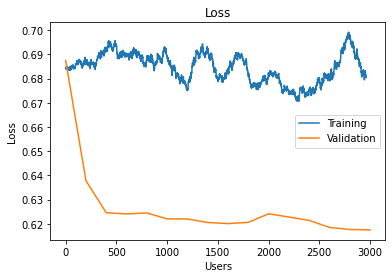

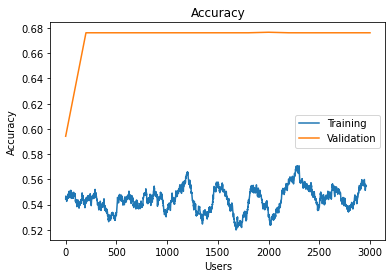

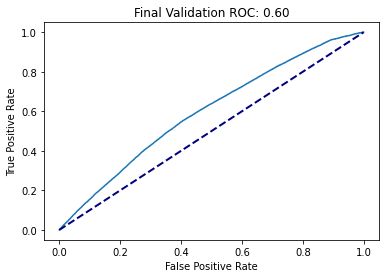





Training with hidden size: 512 and learning rate: 5e-05
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.47453976306227413
Validation Loss: 0.6953275772789975


User Number: 200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.621365870442578


User Number: 400
Validation Accuracy: 0.6764803575203068
Validation Loss: 0.6287464916425913


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6177081089627706


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6171910021620917


User Number: 1000
Validation Accuracy: 0.6788356433251804
Validation Loss: 0.6183425253827005


User Number: 1200
Validation Accuracy: 0.6792986482269932
Validation Loss: 0.6166348976202085


User Number: 1400
Validation Accuracy: 0.6826302704552546
Validation Loss: 0.6177408358588581


User Number: 1600
Validation Accuracy: 0.68047629112943
Validation Loss: 0.6152959136380961


User Number: 1800
Validation Accuracy: 0.6832039939205443
Validation Loss: 0.6178415893534659


User 

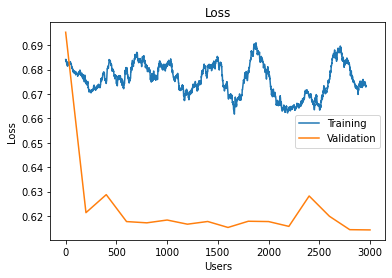

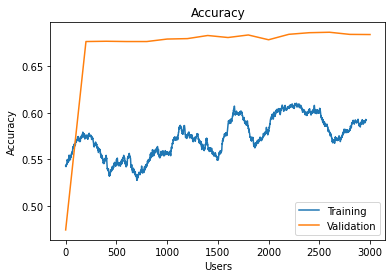

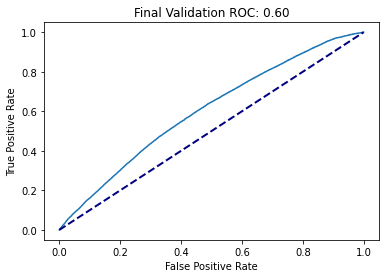





Training with hidden size: 1024 and learning rate: 5e-06
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.595766524745599
Validation Loss: 0.6879284465516098


User Number: 200
Validation Accuracy: 0.6762488550694004
Validation Loss: 0.6565111019371599


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6446889428003828


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6255209712152773


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6252089310410631


User Number: 1000
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6240917305100027


User Number: 1200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6233776859529864


User Number: 1400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6235780760865894


User Number: 1600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6228951476136002


User Number: 1800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6223673281542453


User

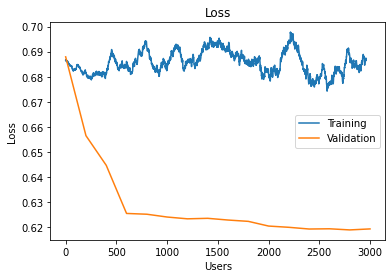

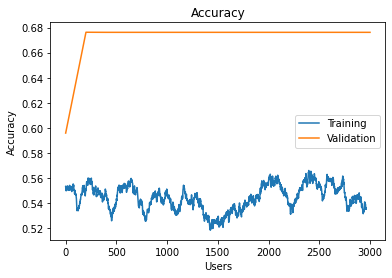

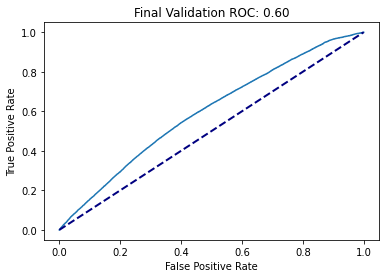





Training with hidden size: 1024 and learning rate: 1e-05
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.32955883685116405
Validation Loss: 0.7097492046458719


User Number: 200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6395460935019027


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6260630270176494


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6249406734472398


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6237130974623216


User Number: 1000
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6207718649411088


User Number: 1200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6203449022254459


User Number: 1400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6200352674833001


User Number: 1600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.620987481098048




In [ ]:
for hidden_size in [128,256,512,1024]:
  for learning_rate in [.000005, 00001,.00005]:
    print("Training with hidden size: {} and learning rate: {}".format(hidden_size,learning_rate))
    run(hidden=hidden_size,
        lr=learning_rate, 
        display_progress=True,
        baseDir='drive/MyDrive/data/',
        display_every=200,
        epochs=1)
    print("\n\n\n")

Performing the last two runs that didn't get to finish

Training with hidden size: 1024 and learning rate: 1e-05
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.4888023271028978
Validation Loss: 0.6937046160916411


User Number: 200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6237060147784674


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6220227215583104


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6216132538755822


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6228108425657937


User Number: 1000
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6222659248606603


User Number: 1200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6215602259942087


User Number: 1400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6219092317973096


User Number: 1600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6211456244861117


User Number: 1800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6193405563819379


Use

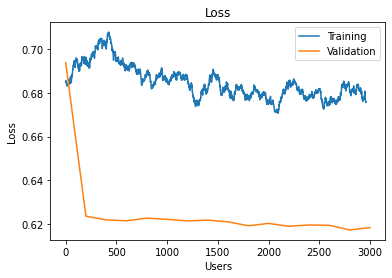

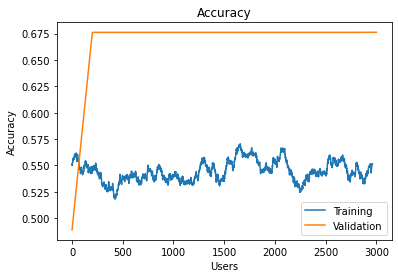

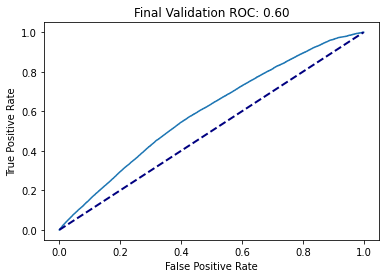





Training with hidden size: 1024 and learning rate: 5e-05
Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.661412567563487
Validation Loss: 0.681659581725394


User Number: 200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6211338895394747


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6201082590717579


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6177030928879372


User Number: 800
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.616570426368016


User Number: 1000
Validation Accuracy: 0.6831536673007821
Validation Loss: 0.633616484215757


User Number: 1200
Validation Accuracy: 0.6820062203702026
Validation Loss: 0.6177046409588662


User Number: 1400
Validation Accuracy: 0.68150295417258
Validation Loss: 0.6155377452319462


User Number: 1600
Validation Accuracy: 0.6853177119505591
Validation Loss: 0.6380263051484328


User Number: 1800
Validation Accuracy: 0.6842004609918371
Validation Loss: 0.6169889649443523


User Numb

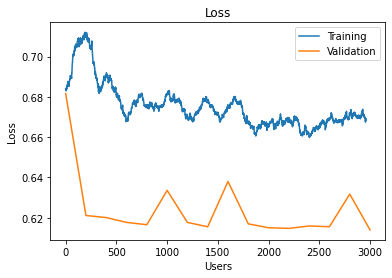

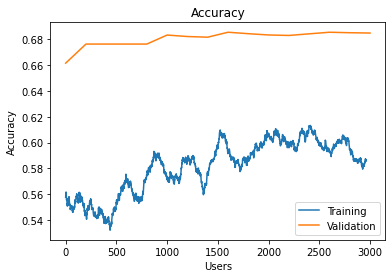

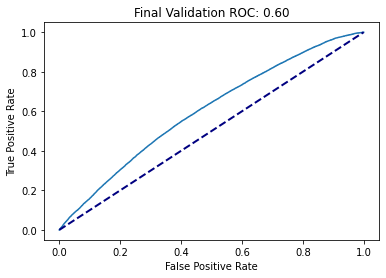

In [ ]:
for hidden_size in [1024]:
  for learning_rate in [.00001,.00005]:
    print("Training with hidden size: {} and learning rate: {}".format(hidden_size,learning_rate))
    run(hidden=hidden_size,
        lr=learning_rate, 
        display_progress=True,
        baseDir='drive/MyDrive/data/',
        display_every=200,
        epochs=1)
    print("\n\n\n")

## Hyperparameter tuning

We find that we get the best accuracy of 68.47% with a hidden size of 1024 and a learning rate of 5e-05. Let's see if we can improve that by increasing the hidden layer size.

Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Read val data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Preprocessing
Beginning Training:

EPOCH: 0
User Number: 0
Validation Accuracy: 0.6363398455979306
Validation Loss: 0.6859318587614679


User Number: 200
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.621517172472376


User Number: 400
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6202204884192893


User Number: 600
Validation Accuracy: 0.6761783978017333
Validation Loss: 0.6172003919277406


User Number: 800
Validation Accuracy: 0.6789463618886574
Validation Loss: 0.6178440179618185


User Number: 1000
Validation Accuracy: 0.6832039939205443
Validation Loss: 0.6243579764322162


User Number: 1200
Validation Accuracy: 0.6781512012964137
Validation Loss: 0.615583343810497


User Number: 1400
Validation Accuracy: 0.6832845165121639
Validation Loss: 0.617393720068222


User Number: 1600
Validation Accuracy: 0.6835160189630703
Validation Loss: 0.6159687711694442


User Number: 1800
Validation Accuracy: 0.6837374560900242
Validation Loss: 0.6174993573811773


User N

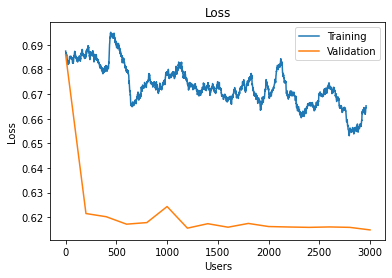

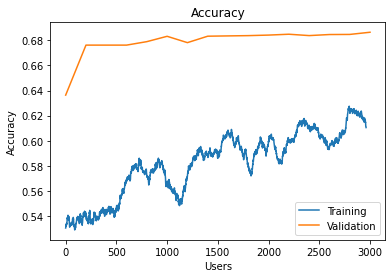

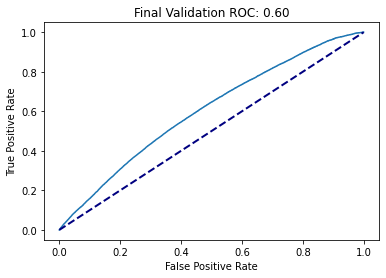

In [ ]:
run(hidden=2048,
        lr=.00005, 
        display_progress=True,
        baseDir='drive/MyDrive/data/',
        display_every=200,
        epochs=1)

Now we see that we get a better accuracy of 68.64% with a hidden size of 2048 and a learning rate of 5e-05. Now we will test the accuracy of our model on the test data. 

Read train data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Preprocessing
Read test data into memory


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Preprocessing
Test Accuracy: 0.6441402822186135
Test Loss: 0.651755204552975


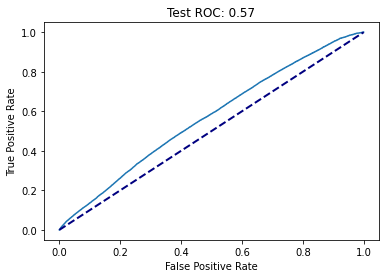

In [ ]:
model = RNN(362,2048,2)
model.load_state_dict(torch.load('drive/MyDrive/data/myModel'))
model.eval()
model.to(device)
criterion = nn.NLLLoss()

_,_,_,_,_, prePipeline = readData('drive/MyDrive/data/')

X, y, u, _, content_types, _ = readData('drive/MyDrive/data/', data_type='test',pipeline=prePipeline)

acc, loss, pred, pred_proba = evaluate(model, criterion, X, y, u,content_types)

print("Test Accuracy:",acc)
print("Test Loss:",loss)

fpr, tpr, _ = roc_curve(y[content_types == 0,0],pred_proba,drop_intermediate=False)
roc_auc = roc_auc_score(y[content_types == 0,0],pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC: %0.2f' % roc_auc)

plt.show()
